In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix, lil_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
from fuzzywuzzy import process

c:\Coding\Python-Henrik-Pedersen-OPA2023\venv\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Labb 1 AI Machine learning advanced

Need to filter the data first since the dataset is 900mb. Looking for different ideas.

In [29]:
# Define minimum ratings per movie and per user
min_ratings_per_movie = 500
min_ratings_per_user = 50

# Specify data types for columns
dtypes = {"userId": "int32", "movieId": "int32", "rating": "float32"}

# Create empty Series to count ratings per movie and per user
movie_counts = pd.Series(dtype=int)
user_counts = pd.Series(dtype=int)


df_movies = pd.read_csv("data/movies.csv", usecols=["movieId", "title", "genres"], dtype={
                        "movieId": "int32", "title": "str", "genres": "str"})


df_ratings = pd.read_csv("data/ratings.csv", dtype=dtypes)

df_filtered = df_ratings[df_ratings["rating"] != 0]

movie_counts = movie_counts.add(
    df_filtered["movieId"].value_counts(), fill_value=0)
user_counts = user_counts.add(
    df_filtered["userId"].value_counts(), fill_value=0)

df_filtered = df_filtered[
    (df_filtered["movieId"].isin(movie_counts[movie_counts >= min_ratings_per_movie].index)) &
    (df_filtered["userId"].isin(
        user_counts[user_counts >= min_ratings_per_user].index))
]

# Merge filtered ratings with movies data
df_combined = pd.merge(df_filtered, df_movies, on="movieId", how="inner")

# EDA and plots!

In [30]:
df_combined

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,1225734739,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,110,4.0,1225865086,Braveheart (1995),Action|Drama|War
2,1,158,4.0,1225733503,Casper (1995),Adventure|Children
3,1,260,4.5,1225735204,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
4,1,356,5.0,1225735119,Forrest Gump (1994),Comedy|Drama|Romance|War
...,...,...,...,...,...,...
28069358,330975,8340,2.0,1091583256,Escape from Alcatraz (1979),Drama|Thriller
28069359,330975,8493,2.5,1091585709,Memphis Belle (1990),Action|Drama|War
28069360,330975,8622,4.0,1091581777,Fahrenheit 9/11 (2004),Documentary
28069361,330975,8665,3.0,1091581765,"Bourne Supremacy, The (2004)",Action|Crime|Thriller


In [56]:
# Descriptive statistics for the numeric columns
print(df_combined.describe())

# Count of unique movies and users
unique_movies = df_combined["movieId"].nunique()
unique_users = df_combined["userId"].nunique()
print(f"Number of unique movies: {unique_movies}")
print(f"Number of unique users: {unique_users}")

# Distribution of ratings
rating_counts = df_combined["rating"].value_counts().sort_index()
print(rating_counts)

# Most rated movies with movie titles
most_rated_movies_indices = df_combined["movieId"].value_counts().head(
    10).index
most_rated_movies = df_combined[df_combined["movieId"].isin(
    most_rated_movies_indices)]
most_rated_movies = most_rated_movies.groupby(
    "movieId")["title"].first()  # Get the movie title
print(most_rated_movies)

# Highest rated movies (with at least 300 ratings), including movie titles and genres
average_ratings = df_combined.groupby(
    "movieId")["rating"].agg(["mean", "count"])
average_ratings = average_ratings[average_ratings["count"] >= 300]
highest_rated_movies_indices = average_ratings.sort_values(
    by="mean", ascending=False).head(10).index
highest_rated_movies = df_combined[df_combined["movieId"].isin(highest_rated_movies_indices)][[
    "movieId", "title", "genres"]].drop_duplicates().set_index("movieId")
highest_rated_movies["average_rating"] = average_ratings["mean"]
print(highest_rated_movies.sort_values(by="average_rating", ascending=False))

# Ratings per user
ratings_per_user = df_combined["userId"].value_counts()
print(ratings_per_user.describe())

             userId       movieId        rating     timestamp
count  2.806936e+07  2.806936e+07  2.806936e+07  2.806936e+07
mean   1.652719e+05  2.545394e+04  3.548716e+00  1.269638e+09
std    9.541532e+04  4.530725e+04  1.046516e+00  2.505622e+08
min    1.000000e+00  1.000000e+00  5.000000e-01  7.896520e+08
25%    8.269800e+04  1.225000e+03  3.000000e+00  1.051325e+09
50%    1.656880e+05  3.175000e+03  4.000000e+00  1.256141e+09
75%    2.474500e+05  3.349300e+04  4.000000e+00  1.495289e+09
max    3.309750e+05  2.868970e+05  5.000000e+00  1.689842e+09
Number of unique movies: 6312
Number of unique users: 130561
rating
0.5     421685
1.0     804892
1.5     453012
2.0    1771518
2.5    1460479
3.0    5282879
3.5    3807284
4.0    7459913
4.5    2663312
5.0    3944389
Name: count, dtype: int64
movieId
260             Star Wars: Episode IV - A New Hope (1977)
296                                   Pulp Fiction (1994)
318                      Shawshank Redemption, The (1994)
356             

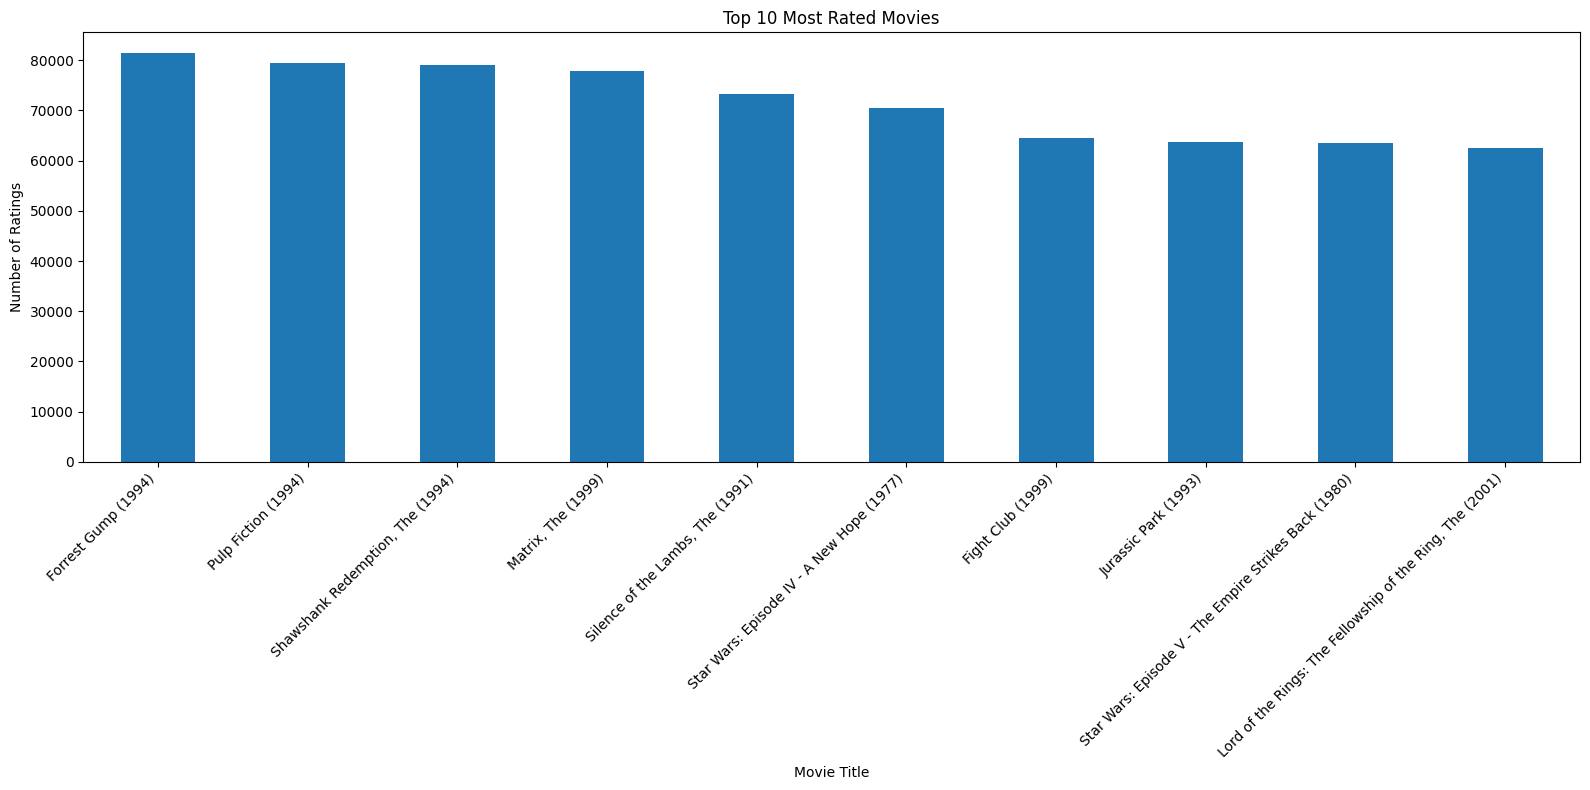

In [32]:
most_rated_movie_ids = df_combined["movieId"].value_counts().head(10).index

most_rated_movies = df_combined[df_combined["movieId"].isin(
    most_rated_movie_ids)]
most_rated_movies = most_rated_movies.groupby("movieId").first()["title"]

rating_counts = df_combined["movieId"].value_counts().loc[most_rated_movie_ids]

# Reorder the titles to match the rating_counts order
ordered_titles = most_rated_movies.reindex(rating_counts.index)

plt.figure(figsize=(16, 8))
rating_counts.plot(kind="bar")
plt.title("Top 10 Most Rated Movies")
plt.xticks(range(len(ordered_titles)), ordered_titles, rotation=45,
           ha="right")  # Set the x-ticks to be the movie titles
plt.xlabel("Movie Title")
plt.ylabel("Number of Ratings")
plt.tight_layout()  # Adjust layout
plt.show()

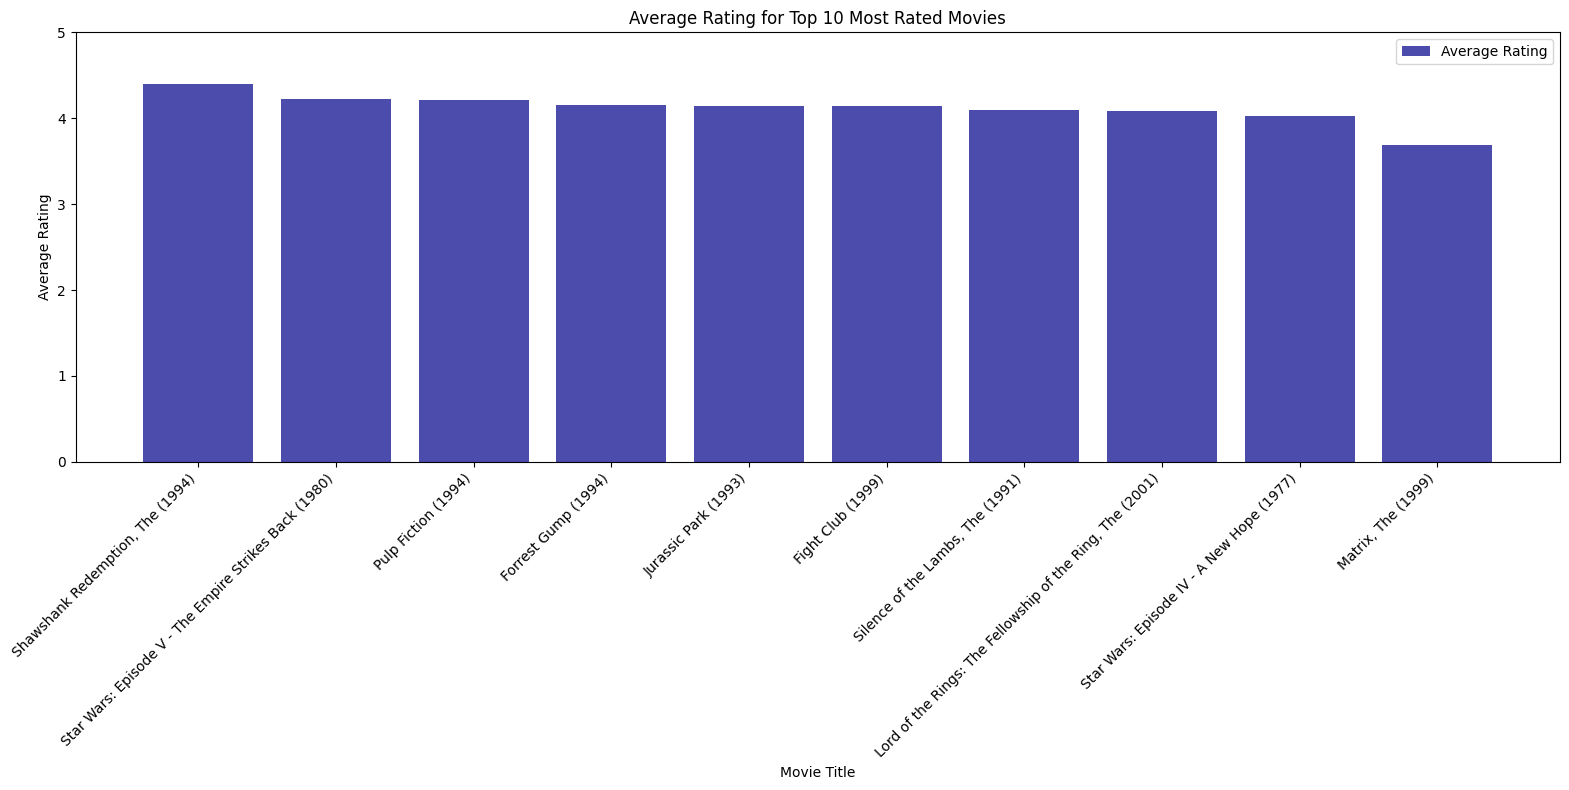

In [7]:
most_rated_movie_ids = df_combined["movieId"].value_counts().head(10).index

most_rated_movies = df_combined[df_combined["movieId"].isin(
    most_rated_movie_ids)]

most_rated_movies = most_rated_movies.groupby("movieId").first()["title"]
average_ratings = df_combined.groupby(
    "movieId")["rating"].mean().loc[most_rated_movie_ids]

most_rated_movies, average_ratings = zip(
    *sorted(zip(most_rated_movies, average_ratings), key=lambda x: x[1], reverse=True))


plt.figure(figsize=(16, 8))

plt.bar(range(len(most_rated_movies)), average_ratings,
        color='darkblue', alpha=0.7, label='Average Rating')

plt.xticks(range(len(most_rated_movies)),
           most_rated_movies, rotation=45, ha="right")
plt.xlabel("Movie Title")
plt.ylabel("Average Rating")
plt.title("Average Rating for Top 10 Most Rated Movies")
plt.ylim(0, 5) 
plt.legend()
plt.tight_layout()
plt.show()

The year release year is in the title, so i i will just slice out the last part and work from there.

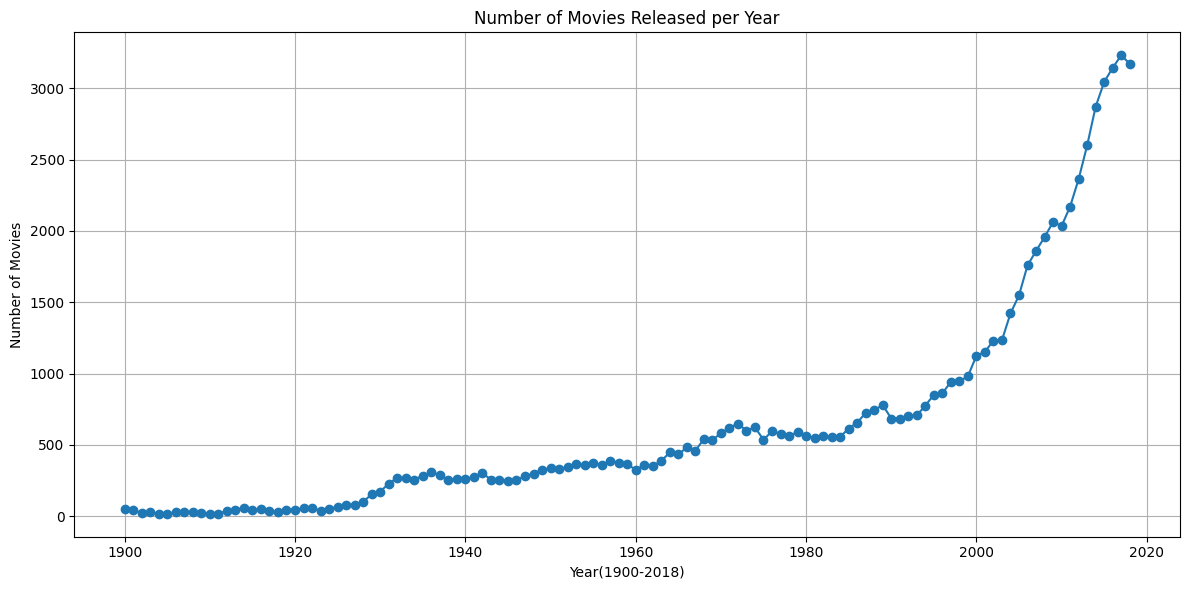

In [33]:
release_years = df_movies['title'].str[-5:-1]   #Just slice out the last part and use it.


release_years = release_years.str.extract('(\d+)').astype(float)    #Gippity

release_years = release_years[(
    release_years >= 1900) & (release_years <= 2018)]

movies_per_year = release_years[0].value_counts().sort_index()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(movies_per_year.index, movies_per_year.values,
         marker='o', linestyle='-')
plt.title('Number of Movies Released per Year')
plt.xlabel('Year(1900-2018)')
plt.ylabel('Number of Movies')
plt.grid(True)
plt.tight_layout()
plt.show()

# Sparse Matrix

In [51]:
def create_sparse_matrix(df_combined):

    user_mapper = dict(zip(np.unique(df_combined["userId"]), list(range(df_combined["userId"].nunique()))))

    movie_mapper = dict(zip(np.unique(df_combined["movieId"]), list(range(df_combined["movieId"].nunique()))))


    user_inv_mapper = dict(zip(list(range(df_combined["userId"].nunique())), np.unique(df_combined["userId"])))

    movie_inv_mapper = dict(zip(list(range(df_combined["movieId"].nunique())), np.unique(df_combined["movieId"])))

    user_index = [user_mapper[i] for i in df_combined["userId"]]
    movie_index = [movie_mapper[i] for i in df_combined["movieId"]]

    sparse_matrix = csr_matrix((df_combined["rating"], (user_index, movie_index)), shape=(

        df_combined["userId"].nunique(), df_combined["movieId"].nunique()))
    
    return sparse_matrix, user_mapper, user_inv_mapper, movie_mapper, movie_inv_mapper


sparse_matrix, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_sparse_matrix(
    df_combined)

In [35]:
sparse_matrix.shape
#User/Movies

(130561, 6312)

In [36]:
n_total = sparse_matrix.shape[0]*sparse_matrix.shape[1]
n_ratings = sparse_matrix.nnz

sparsity = n_ratings/n_total

print(f"Matrix Sparcity:{round(sparsity*100,2)}% ")

Matrix Sparcity:3.41% 


In [37]:
n_ratings_per_user = sparse_matrix.getnnz(axis=1)

len(n_ratings_per_user)

130561

In [38]:
n_ratings_per_user.max()

5326

In [39]:
n_ratings_per_user.min()

3

In [40]:
n_ratings_per_user.mean()

214.99041061266382

In [60]:
print("Unique Movie IDs in Dataset:")
print(df_movies['movieId'].unique())

Unique Movie IDs in Dataset:
[     1      2      3 ... 288975 288977 288983]


In [59]:
print("Unique Movie IDs in Dataset:")
print(df_combined['movieId'].unique())

Unique Movie IDs in Dataset:
[    1   110   158 ...  8405  7042 93982]


In [57]:
print("Sparse Matrix Dimensions:", sparse_matrix.shape)

Sparse Matrix Dimensions: (130561, 6312)


C:\Users\Delic\AppData\Local\Temp\ipykernel_14360\1103078765.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(n_ratings_per_user, shade=True)
C:\Users\Delic\AppData\Local\Temp\ipykernel_14360\1103078765.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(n_ratings_per_user, shade=True)


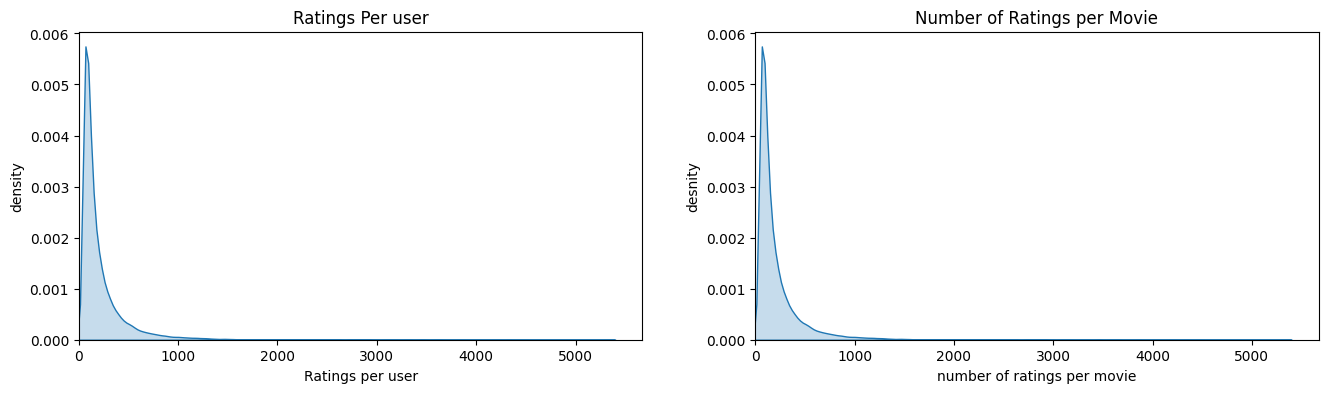

In [41]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, shade=True)
plt.xlim(0)
plt.title("Ratings Per user")
plt.xlabel("Ratings per user")
plt.ylabel("density")

plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_user, shade=True)
plt.xlim(0)

plt.title("Number of Ratings per Movie")
plt.xlabel("number of ratings per movie")

plt.ylabel("desnity")
plt.show()

{0: 1,
 1: 2,
 2: 3,
 3: 4,
 4: 5,
 5: 6,
 6: 7,
 7: 8,
 8: 9,
 9: 10,
 10: 11,
 11: 12,
 12: 13,
 13: 14,
 14: 15,
 15: 16,
 16: 17,
 17: 18,
 18: 19,
 19: 20,
 20: 21,
 21: 22,
 22: 23,
 23: 24,
 24: 25,
 25: 26,
 26: 27,
 27: 28,
 28: 29,
 29: 30,
 30: 31,
 31: 32,
 32: 34,
 33: 35,
 34: 36,
 35: 38,
 36: 39,
 37: 40,
 38: 41,
 39: 42,
 40: 43,
 41: 44,
 42: 45,
 43: 46,
 44: 47,
 45: 48,
 46: 50,
 47: 52,
 48: 54,
 49: 55,
 50: 57,
 51: 58,
 52: 60,
 53: 61,
 54: 62,
 55: 63,
 56: 64,
 57: 65,
 58: 66,
 59: 68,
 60: 69,
 61: 70,
 62: 71,
 63: 72,
 64: 73,
 65: 74,
 66: 75,
 67: 76,
 68: 78,
 69: 79,
 70: 80,
 71: 81,
 72: 82,
 73: 83,
 74: 85,
 75: 86,
 76: 87,
 77: 88,
 78: 89,
 79: 92,
 80: 93,
 81: 94,
 82: 95,
 83: 96,
 84: 97,
 85: 99,
 86: 100,
 87: 101,
 88: 102,
 89: 103,
 90: 104,
 91: 105,
 92: 107,
 93: 110,
 94: 111,
 95: 112,
 96: 113,
 97: 116,
 98: 117,
 99: 118,
 100: 121,
 101: 122,
 102: 123,
 103: 125,
 104: 126,
 105: 132,
 106: 135,
 107: 140,
 108: 141,
 109: 

In [48]:
def build_knn_model(sparse_matrix):
    # Initialize the KNN model
    knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
    # Fit the model to the sparse matrix
    knn_model.fit(sparse_matrix)
    return knn_model


knn_model = build_knn_model(sparse_matrix)

In [50]:
def find_similar_movies(movie_id, k=5):
    # Find the index of the movie in the sparse matrix
    movie_index = movie_mapper.get(movie_id)
    if movie_index is None:
        print(f"Movie ID {movie_id} not found in the mapper.")
        return []

    # Find k nearest neighbors for the given movie
    distances, indices = knn_model.kneighbors(
        sparse_matrix[movie_index], n_neighbors=k+1)

    # Exclude the first neighbor as it will be the movie itself
    similar_movies = []
    for i, idx in enumerate(indices.flatten()[1:]):
        if idx in movie_inv_mapper:
            movie_id = movie_inv_mapper[idx]
            similarity = 1 - distances[0, i]
            similar_movies.append((movie_id, similarity))
        else:
            print(f"Movie ID {idx} not found in the inverse mapper.")

    return similar_movies


# Example: Find similar movies to a given movie (movieId=1)
similar_movies = find_similar_movies(1)
print("Similar movies to 'Toy Story (1995)':")
for movie_id, similarity in similar_movies:
    movie_title = df_movies[df_movies['movieId']
                            == movie_id]['title'].values[0]
    print(f"{movie_title} (ID: {movie_id}), Similarity: {similarity:.2f}")

Movie ID 32399 not found in the inverse mapper.
Movie ID 54160 not found in the inverse mapper.
Movie ID 102409 not found in the inverse mapper.
Movie ID 73555 not found in the inverse mapper.
Movie ID 128970 not found in the inverse mapper.
Similar movies to 'Toy Story (1995)':
